# Análise de Clusterização em Dados de Desenvolvimento de Países
## Anderson Correa - Algoritmos de Clusterização

Este notebook realiza análise de clusterização em dados socioeconômicos e de saúde para determinar índices de desenvolvimento de países.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Carregamento dos Dados

In [2]:
df = pd.read_csv('Country-data.csv')
print(f"Formato do dataset: {df.shape}")
df.head()

Formato do dataset: (167, 10)


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


## 2. Análise Exploratória dos Dados

In [3]:
num_paises = df['country'].nunique()
print(f"Número de países no dataset: {num_paises}")
print(f"\nInformações do Dataset:")
df.info()

Número de países no dataset: 167

Informações do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [4]:
print("Resumo Estatístico:")
df.describe()

Resumo Estatístico:


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [5]:
print("Valores faltantes:")
print(df.isnull().sum())

Valores faltantes:
country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


### 2.1 Visualização da Faixa Dinâmica

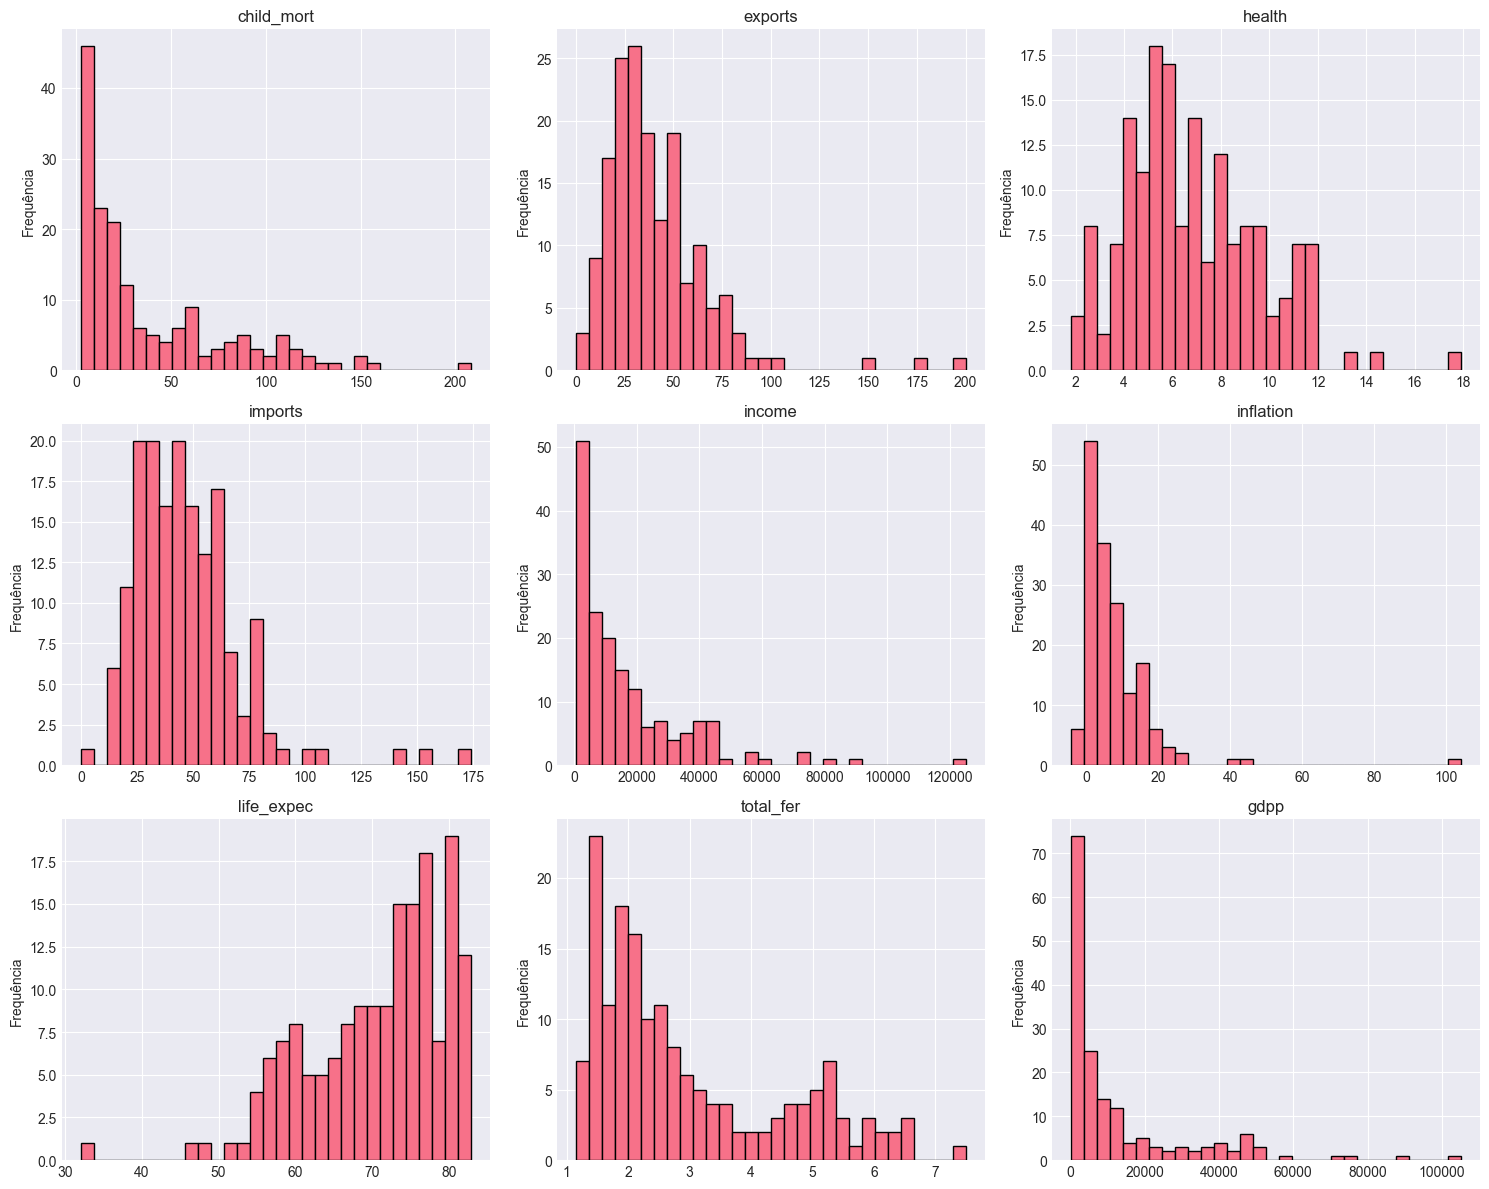

In [6]:
colunas_numericas = df.select_dtypes(include=[np.number]).columns

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(colunas_numericas):
    axes[idx].hist(df[col], bins=30, edgecolor='black')
    axes[idx].set_title(f'{col}')
    axes[idx].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

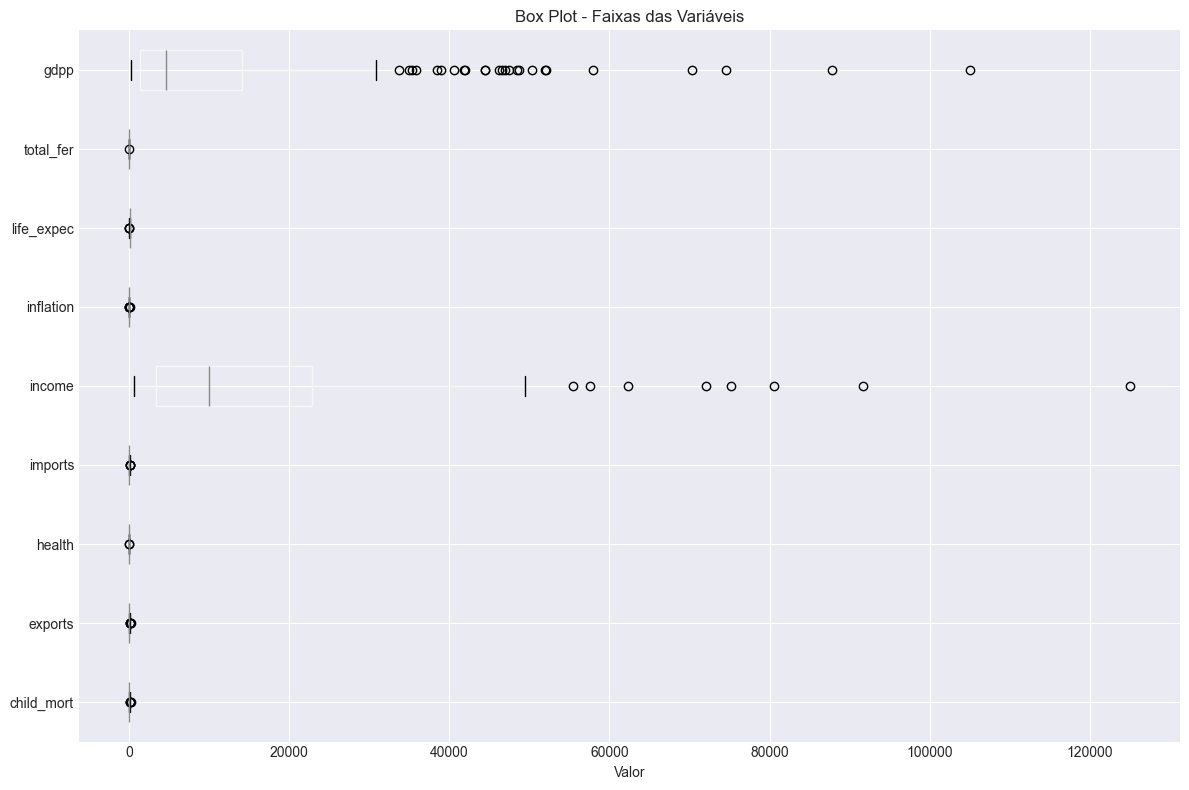

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))
df[colunas_numericas].boxplot(ax=ax, vert=False)
plt.title('Box Plot - Faixas das Variáveis')
plt.xlabel('Valor')
plt.tight_layout()
plt.show()

## 3. Pré-processamento dos Dados

As variáveis possuem escalas diferentes. Algoritmos de clusterização são sensíveis a diferenças de escala, portanto é necessária a padronização.

In [8]:
features = df[colunas_numericas]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled_df = pd.DataFrame(features_scaled, columns=colunas_numericas, index=df.index)

print("Amostra dos dados padronizados:")
print(features_scaled_df.head())

Amostra dos dados padronizados:
   child_mort   exports    health   imports    income  inflation  life_expec  \
0    1.291532 -1.138280  0.279088 -0.082455 -0.808245   0.157336   -1.619092   
1   -0.538949 -0.479658 -0.097016  0.070837 -0.375369  -0.312347    0.647866   
2   -0.272833 -0.099122 -0.966073 -0.641762 -0.220844   0.789274    0.670423   
3    2.007808  0.775381 -1.448071 -0.165315 -0.585043   1.387054   -1.179234   
4   -0.695634  0.160668 -0.286894  0.497568  0.101732  -0.601749    0.704258   

   total_fer      gdpp  
0   1.902882 -0.679180  
1  -0.859973 -0.485623  
2  -0.038404 -0.465376  
3   2.128151 -0.516268  
4  -0.541946 -0.041817  


## 4. Clusterização K-Means (k=3)

In [9]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster_kmeans'] = kmeans.fit_predict(features_scaled)

print("Distribuição dos clusters:")
print(df['cluster_kmeans'].value_counts().sort_index())

Distribuição dos clusters:
cluster_kmeans
0    36
1    47
2    84
Name: count, dtype: int64


### 4.1 Análise dos Resultados do K-Means

In [10]:
for cluster in range(3):
    print(f"\n{'='*60}")
    print(f"Análise do Cluster {cluster}")
    print(f"{'='*60}")
    dados_cluster = df[df['cluster_kmeans'] == cluster]
    print(f"\nNúmero de países: {len(dados_cluster)}")
    print(f"\nValores médios de cada dimensão:")
    print(dados_cluster[colunas_numericas].mean())
    print(f"\nPaíses no cluster:")
    print(dados_cluster['country'].tolist())


Análise do Cluster 0

Número de países: 36

Valores médios de cada dimensão:
child_mort        5.000000
exports          58.738889
health            8.807778
imports          51.491667
income        45672.222222
inflation         2.671250
life_expec       80.127778
total_fer         1.752778
gdpp          42494.444444
dtype: float64

Países no cluster:
['Australia', 'Austria', 'Bahrain', 'Belgium', 'Brunei', 'Canada', 'Cyprus', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Kuwait', 'Luxembourg', 'Malta', 'Netherlands', 'New Zealand', 'Norway', 'Portugal', 'Qatar', 'Singapore', 'Slovak Republic', 'Slovenia', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'United Arab Emirates', 'United Kingdom', 'United States']

Análise do Cluster 1

Número de países: 47

Valores médios de cada dimensão:
child_mort      92.961702
exports         29.151277
health           6.388511
imports         42.323404
income        3942

### 4.2 País Mais Próximo de Cada Centróide

In [11]:
centroides = kmeans.cluster_centers_

for cluster in range(3):
    pontos_cluster = features_scaled[df['cluster_kmeans'] == cluster]
    paises_cluster = df[df['cluster_kmeans'] == cluster]['country'].values
    
    distancias = cdist([centroides[cluster]], pontos_cluster, 'euclidean')[0]
    idx_mais_proximo = np.argmin(distancias)
    
    print(f"\nCluster {cluster}:")
    print(f"  País representativo: {paises_cluster[idx_mais_proximo]}")
    print(f"  Distância ao centróide: {distancias[idx_mais_proximo]:.4f}")


Cluster 0:
  País representativo: Iceland
  Distância ao centróide: 0.7318

Cluster 1:
  País representativo: Guinea
  Distância ao centróide: 0.8291

Cluster 2:
  País representativo: Jamaica
  Distância ao centróide: 0.7344


### 4.3 Visualização K-Means

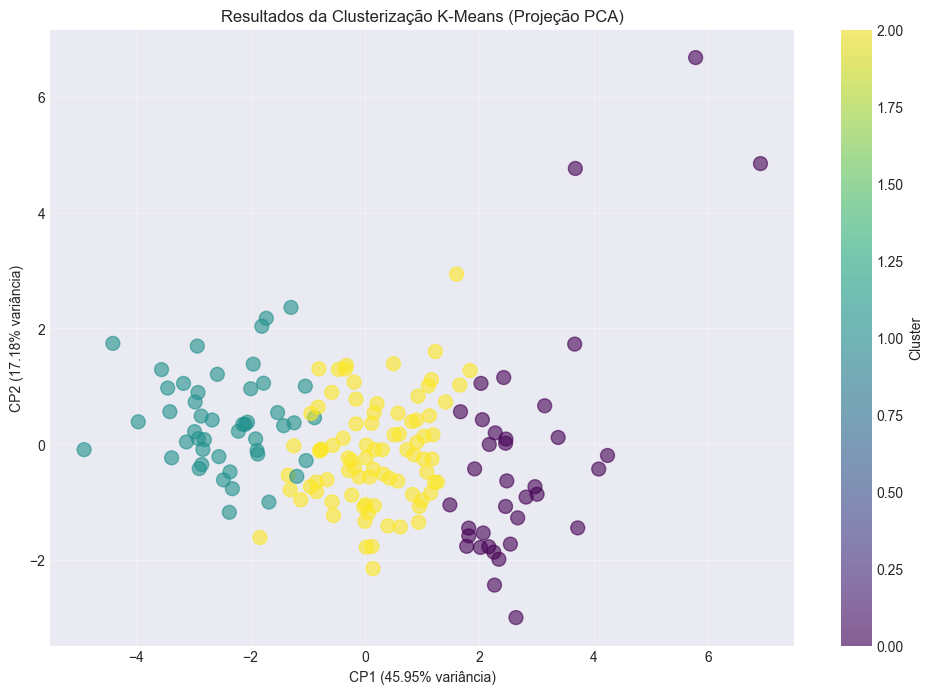

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], 
                     c=df['cluster_kmeans'], cmap='viridis', s=100, alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'CP1 ({pca.explained_variance_ratio_[0]:.2%} variância)')
plt.ylabel(f'CP2 ({pca.explained_variance_ratio_[1]:.2%} variância)')
plt.title('Resultados da Clusterização K-Means (Projeção PCA)')
plt.grid(True, alpha=0.3)
plt.show()

## 5. Clusterização Hierárquica

In [13]:
hierarquico = AgglomerativeClustering(n_clusters=3, linkage='ward')
df['cluster_hierarquico'] = hierarquico.fit_predict(features_scaled)

print("Distribuição dos clusters:")
print(df['cluster_hierarquico'].value_counts().sort_index())

Distribuição dos clusters:
cluster_hierarquico
0     34
1    106
2     27
Name: count, dtype: int64


### 5.1 Dendrograma

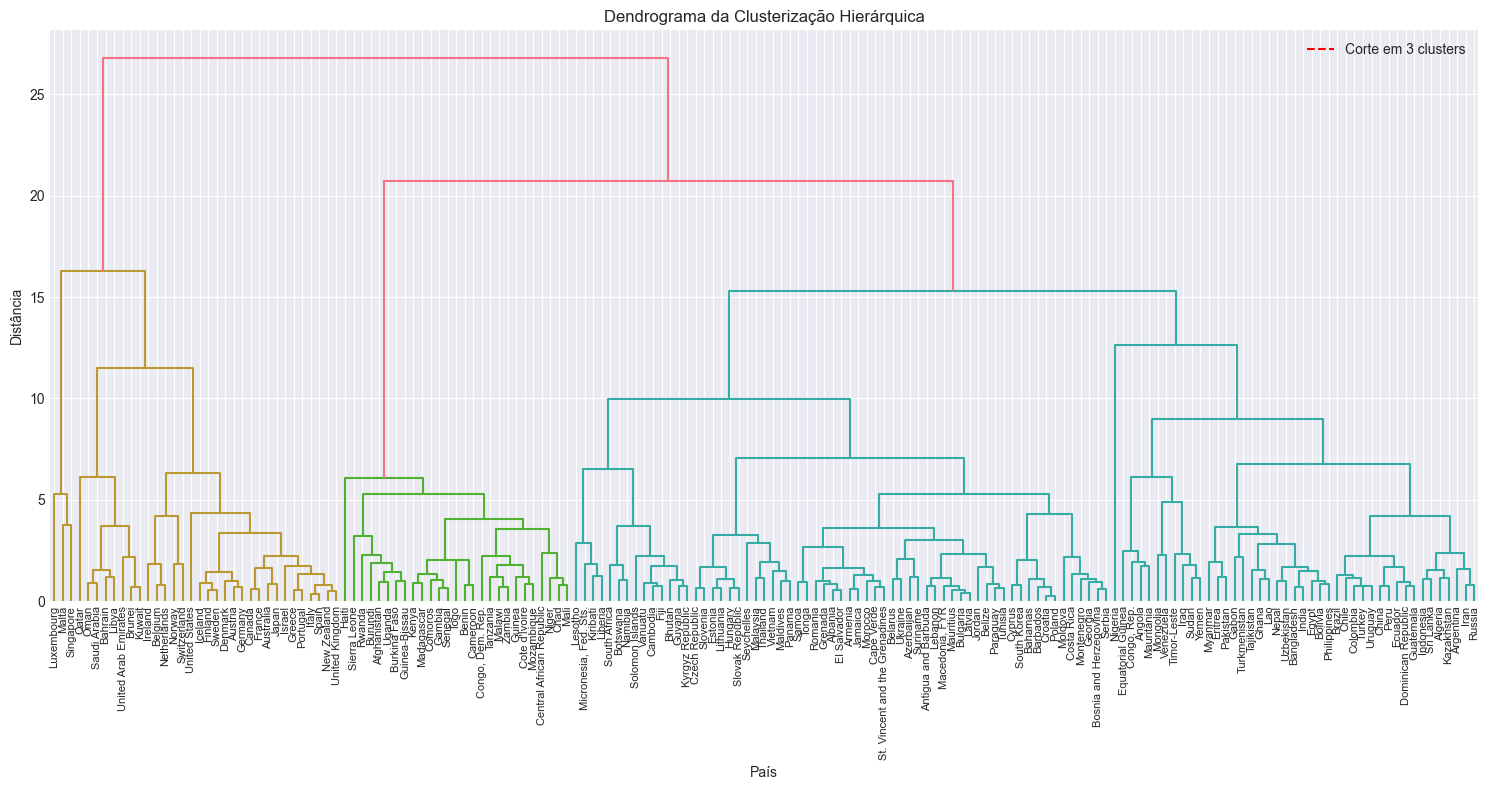

In [14]:
matriz_ligacao = linkage(features_scaled, method='ward')

plt.figure(figsize=(15, 8))
dendrogram(matriz_ligacao, labels=df['country'].values, leaf_font_size=8)
plt.title('Dendrograma da Clusterização Hierárquica')
plt.xlabel('País')
plt.ylabel('Distância')
plt.axhline(y=50, color='r', linestyle='--', label='Corte em 3 clusters')
plt.legend()
plt.tight_layout()
plt.show()

### 5.2 Análise da Clusterização Hierárquica

In [15]:
for cluster in range(3):
    print(f"\n{'='*60}")
    print(f"Análise do Cluster Hierárquico {cluster}")
    print(f"{'='*60}")
    dados_cluster = df[df['cluster_hierarquico'] == cluster]
    print(f"\nNúmero de países: {len(dados_cluster)}")
    print(f"\nValores médios de cada dimensão:")
    print(dados_cluster[colunas_numericas].mean())
    print(f"\nPaíses no cluster:")
    print(dados_cluster['country'].tolist())


Análise do Cluster Hierárquico 0

Número de países: 34

Valores médios de cada dimensão:
child_mort        5.961765
exports          58.508824
health            8.501176
imports          48.902941
income        47588.235294
inflation         4.115500
life_expec       79.982353
total_fer         1.888529
gdpp          43170.588235
dtype: float64

Países no cluster:
['Australia', 'Austria', 'Bahrain', 'Belgium', 'Brunei', 'Canada', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Kuwait', 'Libya', 'Luxembourg', 'Malta', 'Netherlands', 'New Zealand', 'Norway', 'Oman', 'Portugal', 'Qatar', 'Saudi Arabia', 'Singapore', 'Spain', 'Sweden', 'Switzerland', 'United Arab Emirates', 'United Kingdom', 'United States']

Análise do Cluster Hierárquico 1

Número de países: 106

Valores médios de cada dimensão:
child_mort       31.617925
exports          39.990368
health            6.353679
imports          48.085527
income        11341.886792
inf

## 6. Comparação K-Means vs Clusterização Hierárquica

In [16]:
comparacao = pd.crosstab(df['cluster_kmeans'], df['cluster_hierarquico'], 
                         rownames=['K-Means'], colnames=['Hierárquico'])
print("Comparação das atribuições de clusters:")
print(comparacao)

Comparação das atribuições de clusters:
Hierárquico   0   1   2
K-Means                
0            31   5   0
1             0  20  27
2             3  81   0


In [17]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(df['cluster_kmeans'], df['cluster_hierarquico'])
print(f"\nÍndice de Rand Ajustado: {ari:.4f}")
print("(1.0 = concordância perfeita, 0.0 = atribuição aleatória)")


Índice de Rand Ajustado: 0.5370
(1.0 = concordância perfeita, 0.0 = atribuição aleatória)


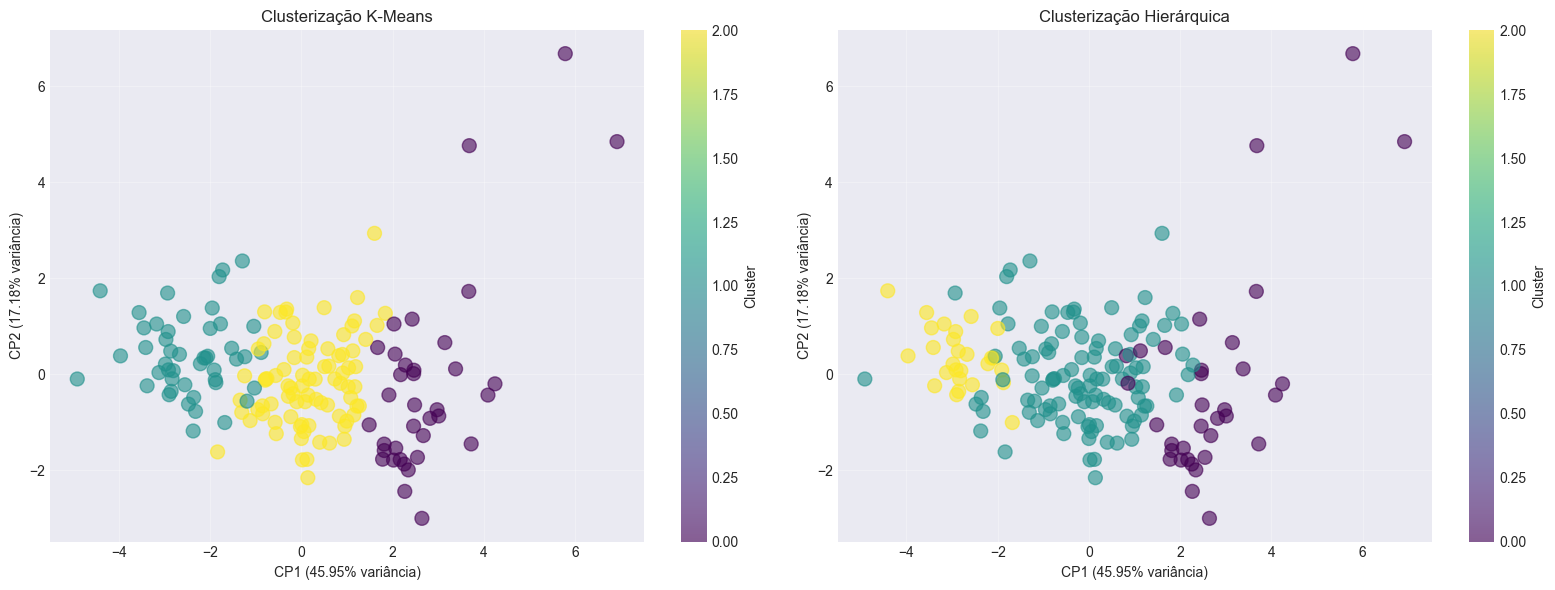

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = axes[0].scatter(features_pca[:, 0], features_pca[:, 1], 
                          c=df['cluster_kmeans'], cmap='viridis', s=100, alpha=0.6)
axes[0].set_xlabel(f'CP1 ({pca.explained_variance_ratio_[0]:.2%} variância)')
axes[0].set_ylabel(f'CP2 ({pca.explained_variance_ratio_[1]:.2%} variância)')
axes[0].set_title('Clusterização K-Means')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

scatter2 = axes[1].scatter(features_pca[:, 0], features_pca[:, 1], 
                          c=df['cluster_hierarquico'], cmap='viridis', s=100, alpha=0.6)
axes[1].set_xlabel(f'CP1 ({pca.explained_variance_ratio_[0]:.2%} variância)')
axes[1].set_ylabel(f'CP2 ({pca.explained_variance_ratio_[1]:.2%} variância)')
axes[1].set_title('Clusterização Hierárquica')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

In [19]:
print("\nResumo dos Resultados Finais:")
print("\nClusters K-Means:")
for cluster in range(3):
    paises = df[df['cluster_kmeans'] == cluster]['country'].tolist()
    print(f"  Cluster {cluster}: {len(paises)} países")

print("\nClusters Hierárquicos:")
for cluster in range(3):
    paises = df[df['cluster_hierarquico'] == cluster]['country'].tolist()
    print(f"  Cluster {cluster}: {len(paises)} países")


Resumo dos Resultados Finais:

Clusters K-Means:
  Cluster 0: 36 países
  Cluster 1: 47 países
  Cluster 2: 84 países

Clusters Hierárquicos:
  Cluster 0: 34 países
  Cluster 1: 106 países
  Cluster 2: 27 países
